# CS4618 - Continuous Assessment

The following notebook contains the CS4618 continuous assessment work for _Jack Moloney_.

Student Number: _120492066_

## Section 0: Imports

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
)
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

from seaborn import heatmap

## Section 1: Data Loading and Exploration

To begin, load the CSV to a pandas dataframe and separate to development and test dataframes, _dev\_df_ and _test\_df_. The split allows to explore the development dataset without being concerned about potential outliers only present in the test dataframe. The _random\_state_ parameter is being used to ensure consistent results when shuffling.

In [4]:
df = pd.read_csv("dataset_shopping.csv")

df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

### Data Exploration

In [5]:
dev_df.shape

(9864, 18)

Dataset has 18 columns, this presents a potential dimensionality issue when performing classification -> initial thoughts are that feature selection will be necessary.

In [6]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9864 entries, 6183 to 7336
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   admin_num_pages   9864 non-null   int64  
 1   admin_duration    9864 non-null   float64
 2   info_num_pages    9864 non-null   int64  
 3   info_duration     9864 non-null   float64
 4   prod_num_pages    9864 non-null   int64  
 5   prod_duration     9864 non-null   float64
 6   bounce_rate       9864 non-null   float64
 7   exit_rate         9864 non-null   float64
 8   page_value        9864 non-null   float64
 9   special_day       9864 non-null   float64
 10  month             9864 non-null   object 
 11  operating_system  9864 non-null   int64  
 12  browser           9864 non-null   int64  
 13  region            9864 non-null   int64  
 14  referrer          9864 non-null   int64  
 15  visitor           9864 non-null   object 
 16  weekend           9864 non-null   bool   
 1

The above info table shows us that we have no null values present in the dataset. However the presence of 'object' typed columns informs us that we will need to convert them from their current, categorical format to numeric (using a strategy like _one-hot encoding_.

There are other categorical columns that need to be encoded including _operating\_system_, _browser_, _region_.

From the above column list, we can create an array of features, which contains all columns except what we are trying to predict; _purchase_ in this case.

In [7]:
features = [
    "admin_num_pages",
    "admin_duration",
    "info_num_pages",
    "info_duration",
    "prod_num_pages",
    "prod_duration",
    "bounce_rate",
    "exit_rate",
    "page_value",
    "special_day",
    "month",
    "operating_system",
    "browser",
    "region",
    "referrer",
    "visitor",
    "weekend",
]

In [8]:
dev_df[features].head(3)

,admin_num_pages,admin_duration,info_num_pages,info_duration,prod_num_pages,prod_duration,bounce_rate,exit_rate,page_value,special_day,month,operating_system,browser,region,referrer,visitor,weekend
6183,0,0.0,0,0.0,4,53.625000,0.00,0.050000,0.000000,0.0,Nov,3,2,1,11,Returning_Visitor,False
9253,0,0.0,0,0.0,5,89.866667,0.04,0.060000,0.000000,0.0,Jul,3,2,5,4,Returning_Visitor,True
2927,1,10.0,0,0.0,32,1277.750000,0.00,0.006061,78.121654,0.0,Dec,8,13,9,20,Other,False


In [9]:
dev_df["referrer"].unique()

array([11,  4, 20,  3,  1,  2, 13,  6, 10,  5,  8, 19,  7, 14,  9, 15, 18,
       17, 16])

Upon further inspection to the source of the [dataset](https://link.springer.com/article/10.1007/s00521-018-3523-0), I found that the _referrer_ column is also likely to be categorical. The _TrafficType_ column is present in the table representing categorical columns with the following description:
> TrafficType | Traffic source by which the visitor has arrived at the Web site (e.g., banner, SMS, direct) | 20

That description leads me to believe that in our dataset _referrer_ represents the same data; this allows me to create the _columns\_to\_encode_ list. Once I perform one-hot encoding on these columns, I can create a list of _categorical\_features_.

**Note:** One-hot encoding this many categorical features will lead to significantly more columns, increasing the dimensionality issue.

In [10]:
nom_features = [
    "month",
    "operating_system",
    "browser",
    "region",
    "referrer",
    "visitor",
]  # 'weekend' excluded due to it already being binarized

In [11]:
dev_df["special_day"].unique()

array([0. , 0.4, 1. , 0.2, 0.8, 0.6])

In [12]:
dev_df["visitor"].unique()

array(['Returning_Visitor', 'Other', 'New_Visitor'], dtype=object)

Non-descriptive value 'Other' requires further investigation, to ensure that it doesn't represent rows that may need to be excluded.

In [13]:
dev_df[dev_df["visitor"] == "Other"]["purchase"].unique()

array([ True, False])

In [14]:
dev_df.describe()

,admin_num_pages,admin_duration,info_num_pages,info_duration,prod_num_pages,prod_duration,bounce_rate,exit_rate,page_value,special_day,operating_system,browser,region,referrer
count,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000
mean,2.314477,81.349603,0.508719,34.319795,31.732157,1195.739928,0.022316,0.043036,5.774288,0.060726,2.119627,2.358273,3.136760,4.083840
std,3.331563,179.194400,1.275545,138.331550,44.553425,1859.836885,0.048753,0.048678,18.616935,0.197968,0.907394,1.716258,2.395933,4.035653
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,183.593750,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,601.059874,0.003073,0.025083,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,92.950000,0.000000,0.000000,38.000000,1470.881445,0.016667,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,2720.500000,24.000000,2256.916667,705.000000,43171.233380,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


<Axes: xlabel='count', ylabel='referrer'>

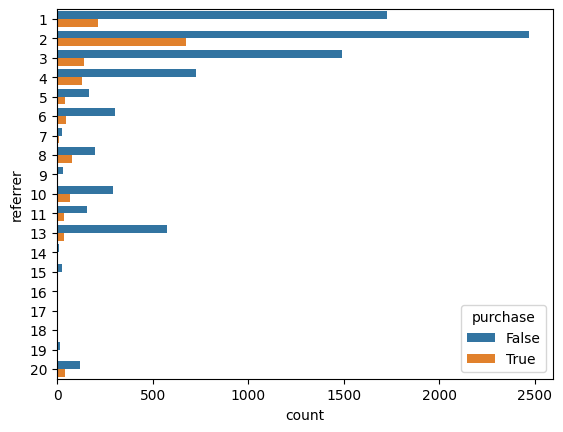

In [15]:
sns.countplot(data=dev_df, y="referrer", hue="purchase")

The code below to generate a grid of plots was generated by ChatGPT with the following prompt.
```
I want to have my seaborn countplots show in a grid, here is what I have:
for cat in columns_to_encode:
    sns.countplot(data=dev_df, y=cat, hue="purchase")
```


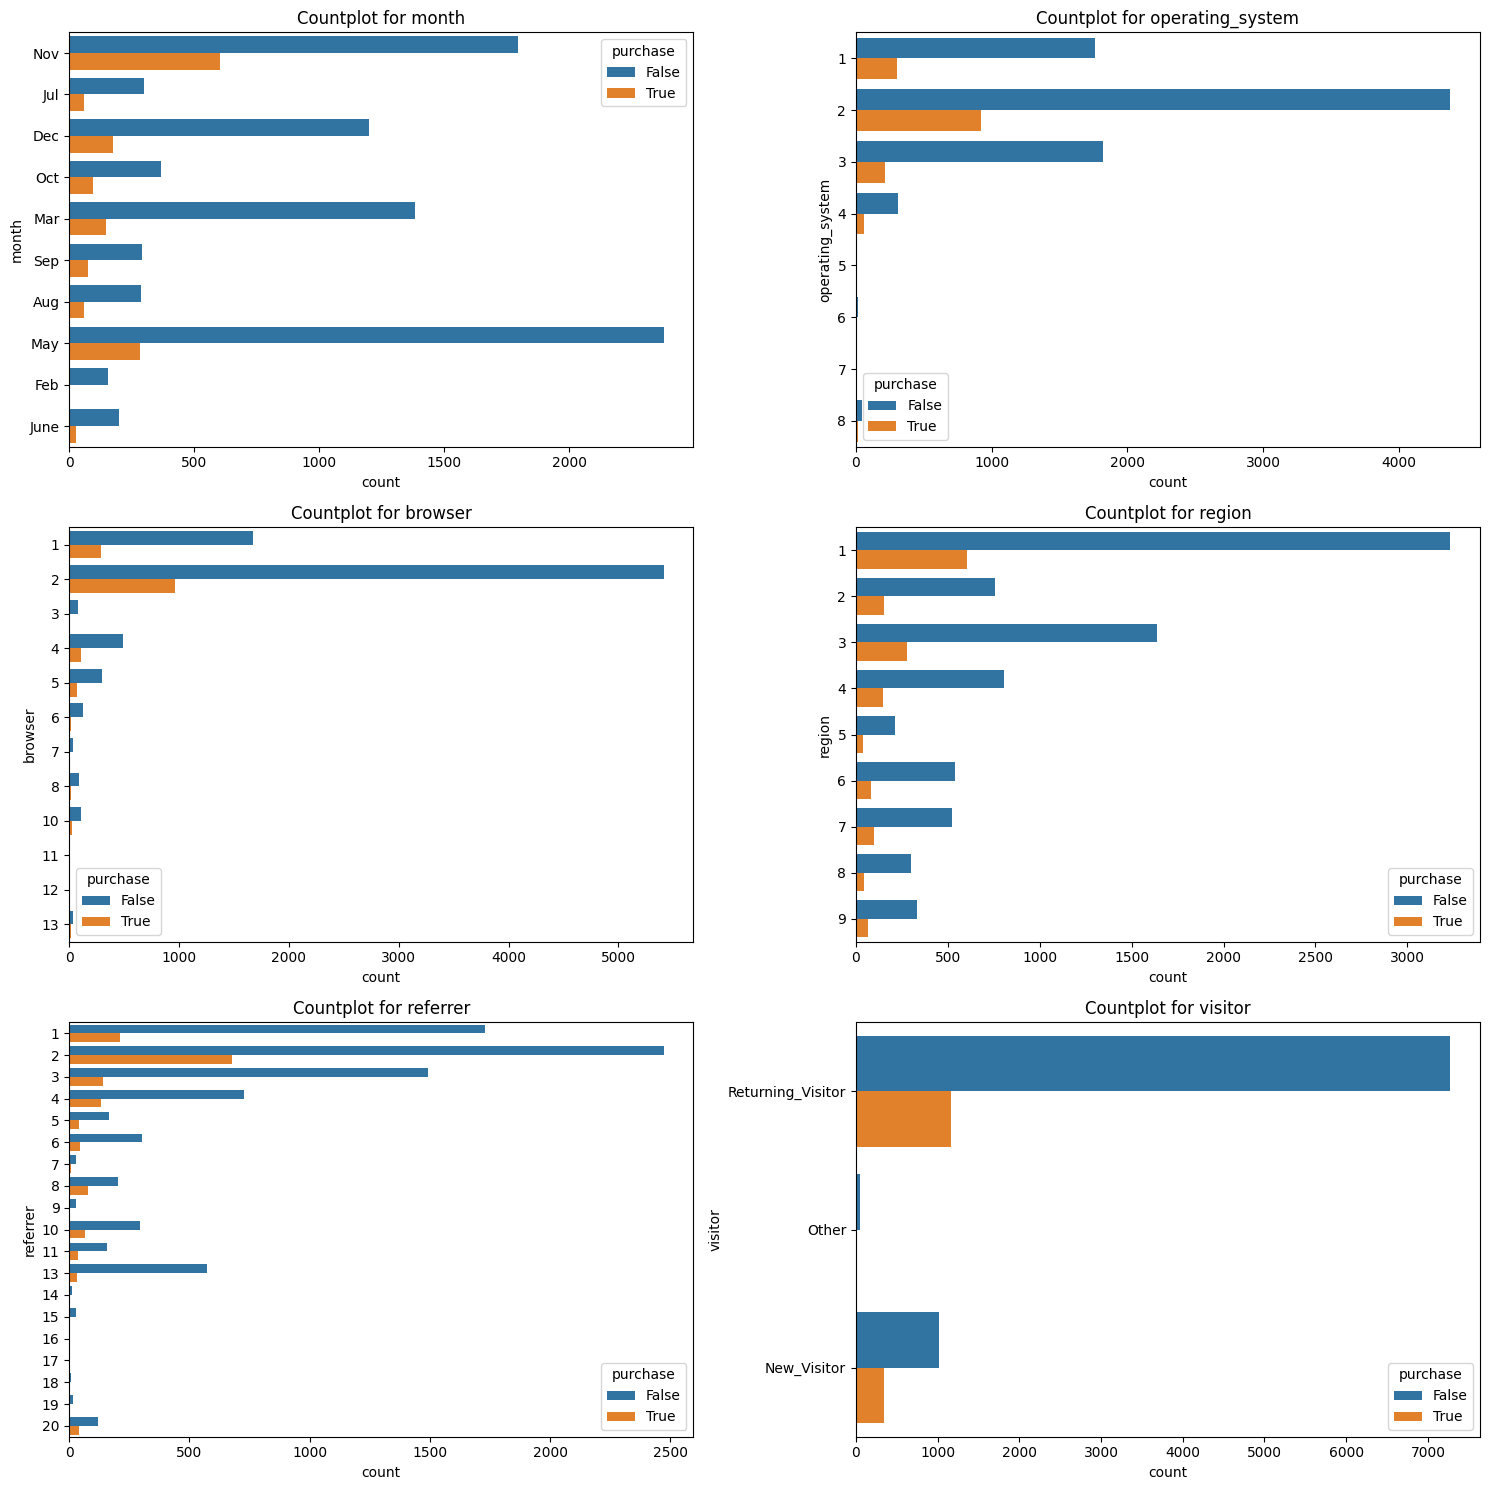

In [16]:
# Determine the number of rows and columns for the grid
n_cols = 2  # Number of columns in the grid
n_rows = (len(nom_features) + n_cols - 1) // n_cols  # Calculate rows needed

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each category and create a countplot
for i, cat in enumerate(nom_features):
    sns.countplot(data=dev_df, y=cat, hue="purchase", ax=axes[i])
    axes[i].set_title(f"Countplot for {cat}")

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

After inspecting the above countplot for month, it highlighted that there aren't 12 months present.

In [17]:
dev_df["month"].unique()

array(['Nov', 'Jul', 'Dec', 'Oct', 'Mar', 'Sep', 'Aug', 'May', 'Feb',
       'June'], dtype=object)

January (Jan) and April (Apr) aren't present, these will be added when performing the encoding in order to more effectively represent the 'real world'.

In [18]:
nom_features

['month', 'operating_system', 'browser', 'region', 'referrer', 'visitor']

In [19]:
dev_df.columns

Index(['admin_num_pages', 'admin_duration', 'info_num_pages', 'info_duration',
       'prod_num_pages', 'prod_duration', 'bounce_rate', 'exit_rate',
       'page_value', 'special_day', 'month', 'operating_system', 'browser',
       'region', 'referrer', 'visitor', 'weekend', 'purchase'],
      dtype='object')

In [20]:
num_features = [
    "admin_num_pages",
    "admin_duration",
    "info_num_pages",
    "info_duration",
    "prod_num_pages",
    "prod_duration",
    "bounce_rate",
    "exit_rate",
    "page_value",
    "special_day",
]

In [21]:
dev_df[num_features].describe()

,admin_num_pages,admin_duration,info_num_pages,info_duration,prod_num_pages,prod_duration,bounce_rate,exit_rate,page_value,special_day
count,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000
mean,2.314477,81.349603,0.508719,34.319795,31.732157,1195.739928,0.022316,0.043036,5.774288,0.060726
std,3.331563,179.194400,1.275545,138.331550,44.553425,1859.836885,0.048753,0.048678,18.616935,0.197968
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,183.593750,0.000000,0.014286,0.000000,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,601.059874,0.003073,0.025083,0.000000,0.000000
75%,4.000000,92.950000,0.000000,0.000000,38.000000,1470.881445,0.016667,0.050000,0.000000,0.000000
max,27.000000,2720.500000,24.000000,2256.916667,705.000000,43171.233380,0.200000,0.200000,361.763742,1.000000


<Axes: >

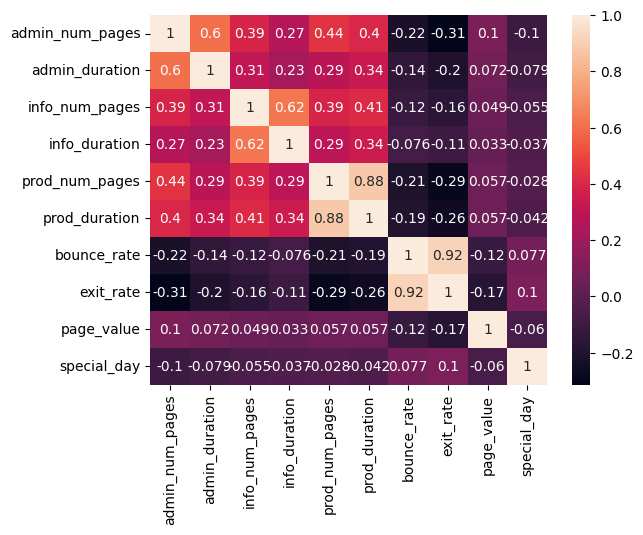

In [22]:
heatmap(dev_df[num_features].corr(), annot=True)

In [23]:
copy_num_df = dev_df[num_features].copy()
copy_num_df = pd.concat(
    [copy_num_df, pd.get_dummies(df["purchase"], prefix="purchase")], axis=1
)
copy_num_df.dtypes

admin_num_pages    float64
admin_duration     float64
info_num_pages     float64
info_duration      float64
prod_num_pages     float64
prod_duration      float64
bounce_rate        float64
exit_rate          float64
page_value         float64
special_day        float64
purchase_False        bool
purchase_True         bool
dtype: object

<Axes: >

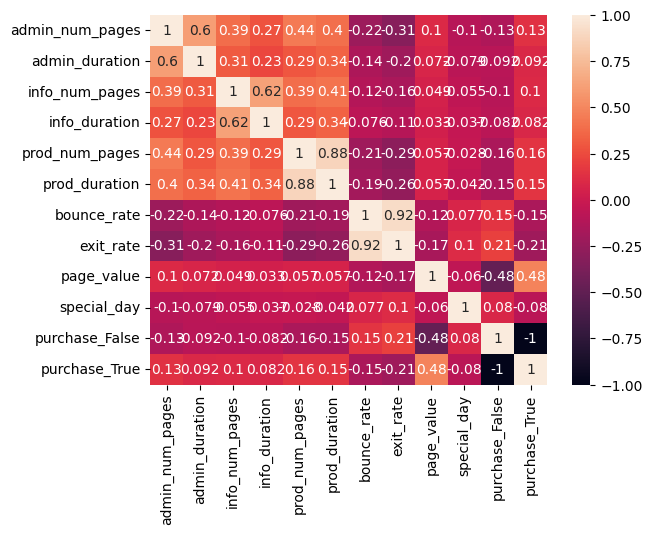

In [24]:
heatmap(copy_num_df.corr(), annot=True)

`page_value` is relatively highly correlated with purchase being True - this column is worth paying attention to. There aren't any with significantly negative correlation.

# Preprocessor

## Categorical Encoding
Before we can check the initial performance, we are first going to perform a simple encoding of the data. I have chosen the one-hot encoding approach due to its simple implementation and efficacy representing non-binary categorical features.

This encoding will be done as part of a pipeline.

In [25]:
# first we load a clean copy of the data
df = pd.read_csv("dataset_shopping.csv")
# then shuffle and reset indices
df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

In [26]:
X = df[features]
y = df["purchase"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

In [27]:
### GENERATED USING CLAUDE 3.5 SONNET ###
PROMPT = """
You are an elite AI professional with over 20 years experience creating machine learning models, with a particular focus on classification. Your responses should be brief and to the point, but not lacking sufficient depth. Don't provide code unless you are specifically asked for it.

Your task is to help me create a model to predict whether a purchase was made or not on an ecommerce website.

I want to create a visual aid to show if a model is overfitting or underfitting using the learning curves, please account for deviation in the data. Use matplotlib.pyplot to generate the code.
"""
from sklearn.model_selection import learning_curve


def plot_learning_curves(estimator, X, y, title, cv=5):
    # Calculate learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring="accuracy",
    )

    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training score", color="blue", marker="o")
    plt.fill_between(
        train_sizes,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.15,
        color="blue",
    )

    plt.plot(
        train_sizes, val_mean, label="Cross-validation score", color="green", marker="o"
    )
    plt.fill_between(
        train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color="green"
    )

    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy Score")
    plt.title(f"Learning Curves - {title}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [28]:
preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_features),
        ("nom", OneHotEncoder(handle_unknown="ignore"), nom_features),
    ]
)

# Initial Performance Check
Before we begin creating features, lets first assess the performance on the dataset without our new features.

## Majority Class Classifier
To begin with we will check what the performance is with a majority class classifier, this is the bare minimum standard we need to meet, or else we haven't learned anything.

In [29]:
from sklearn.dummy import DummyClassifier

majority_clf = DummyClassifier(strategy="most_frequent", random_state=2)
mc_model = Pipeline([("preprocessor", preprocessor), ("classifier", majority_clf)])
mc_model.fit(X_train, y_train)
mc_preds = mc_model.predict(X_test)

In [30]:
print("Majority Class Classifier Test Accuracy:", accuracy_score(y_test, mc_preds))
print(
    "Majority Class Classifier Training Accuracy:",
    accuracy_score(y_train, mc_model.predict(X_train)),
)

Majority Class Classifier Test Accuracy: 0.8450932684509327
Majority Class Classifier Training Accuracy: 0.8452960259529603


## Decision Tree

In [31]:
dt_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=2)),
    ]
)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

In [32]:
print("Decision Tree Test Accuracy:", accuracy_score(y_test, dt_preds))
print(
    "Decision Tree Training Accuracy:",
    accuracy_score(y_train, dt_model.predict(X_train)),
)

Decision Tree Test Accuracy: 0.8523925385239254
Decision Tree Training Accuracy: 1.0


In [33]:
# plot_learning_curves(dt_model, X_train, y_train, "Decision Tree Classifier") # Redundant visual - training score should always be 1.0 for DTClassifier

In [34]:
def plot_tree_depth_analysis(X, y, cv=5):
    train_scores = []
    val_scores = []
    max_depths = range(1, 21)  # Test depths 1 to 20

    for depth in max_depths:
        dt = Pipeline(
            [
                ("preprocessor", preprocessor),
                ("classifier", DecisionTreeClassifier(max_depth=depth)),
            ]
        )
        train_score = np.mean(cross_val_score(dt, X, y, cv=cv))
        dt.fit(X, y)
        train_scores.append(dt.score(X, y))
        val_scores.append(train_score)

    plt.figure(figsize=(10, 6))
    plt.plot(max_depths, train_scores, label="Training Score", marker="o")
    plt.plot(max_depths, val_scores, label="Cross-validation Score", marker="o")
    plt.xlabel("Max Tree Depth")
    plt.ylabel("Accuracy Score")
    plt.title("Decision Tree Depth Analysis")
    plt.legend()
    plt.grid(True)
    plt.show()

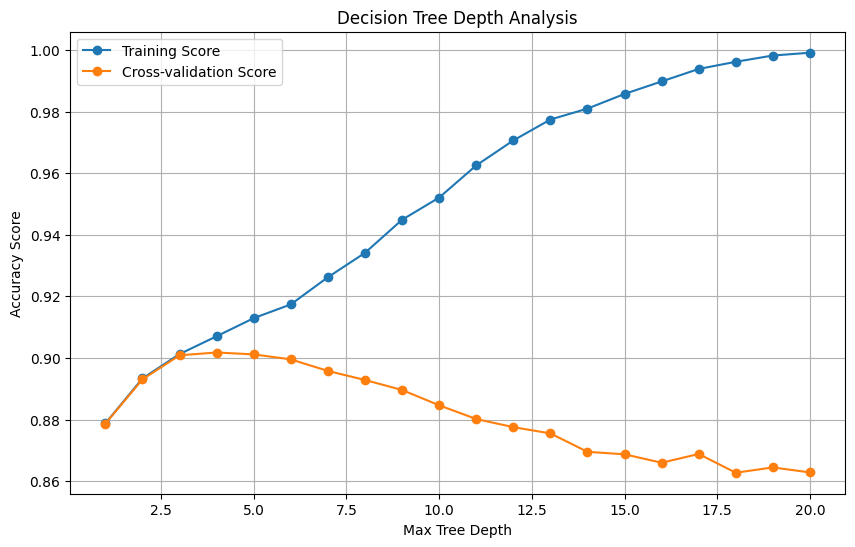

In [35]:
plot_tree_depth_analysis(X_train, y_train)

## KNN
Grid search will be performed with ```n``` up to 10 for KNN.

In [36]:
knn_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier(n_neighbors=9)),
    ]
)
#
# param_grid = {
#         "classifier__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# }
#
# gs = GridSearchCV(knn_model, param_grid)
# gs.fit(X_train, y_train)
# gs.best_params_
# output: classifier__n_neighbors: 9
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

In [37]:
print("KNN Test Accuracy:", accuracy_score(y_test, knn_preds))
print("KNN Training Accuracy:", accuracy_score(y_train, knn_model.predict(X_train)))

KNN Test Accuracy: 0.875506893755069
KNN Training Accuracy: 0.8957826439578265


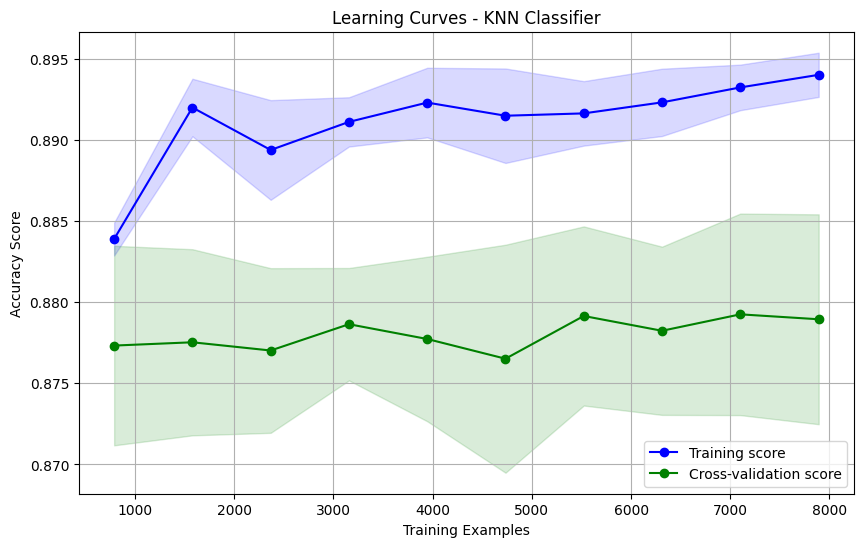

In [38]:
plot_learning_curves(knn_model, X_train, y_train, "KNN Classifier")

## Random Forest

In [39]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=4,
    class_weight="balanced",  # we already stratified when splitting train/test
    random_state=2,
)
rf_model = Pipeline([("preprocessor", preprocessor), ("classifier", rf)])
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [40]:
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_preds))
print("Random Forest Accuracy:", accuracy_score(y_train, rf_model.predict(X_train)))

Random Forest Test Accuracy: 0.8609083536090836
Random Forest Accuracy: 0.8888888888888888


## Initial Thoughts
Each of these more complex classifiers are currently only performing marginally better than a simple majority class classifier; we will now attempt to improve these more complex models through *feature engineering*.

# Feature Engineering

## Session Behaviour Metrics
We are going to inspect session behaviour metrics to begin with including:
- time per page ratios
- total session metrics
- page type distribution
- engagement time
- research behaviour (```prod_num_pages/(info_num_pages + 1)```)

These metrics should give us an insight to the overall quality of the session.

### Time Per Page Ratios
Higher time per page (TPP) could either be indicative, or contra-indicative to purchase intent. I expect that higher time on admin pages is less desirable (likely signals user confusion), while higher TPP on info/product pages denotes deeper engagement with the content (and thus higher interest).

In [41]:
class InsertAdminTPP(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self, input_features=None):
        return ["admin_tpp"]

    def transform(self, X, y=None):
        if self.insert:
            X["admin_tpp"] = X["admin_duration"] / X["admin_num_pages"]
            X = X.replace([np.inf, -np.inf], np.nan)
        return X


class InsertInfoTPP(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self, input_features=None):
        return ["info_tpp"]

    def transform(self, X, y=None):
        if self.insert:
            X["info_tpp"] = X["info_duration"] / X["info_num_pages"]
            X = X.replace([np.inf, -np.inf], np.nan)
        return X


class InsertProdTPP(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self, input_features=None):
        return ["prod_tpp"]

    def transform(self, X, y=None):
        if self.insert:
            X["prod_tpp"] = X["prod_duration"] / X["prod_num_pages"]
            X = X.replace([np.inf, -np.inf], np.nan)
        return X


class InsertOverallTPP(BaseEstimator, TransformerMixin):  # Pseudometric for engagement
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self, input_features=None):
        return ["overall_tpp"]

    def transform(self, X, y=None):
        if self.insert:
            X["overall_tpp"] = (
                X["admin_duration"] + X["info_duration"] + X["prod_duration"]
            ) / (X["admin_num_pages"] + X["info_num_pages"] + X["prod_num_pages"] + 1)
            X = X.replace([np.inf, -np.inf], np.nan)
        return X

### Total Session Metrics
The total session metrics (i.e. total pages visited and total duration) should be an indicator of whether a user is a window shopper, or a user more likely to purchase.

In [42]:
class InsertTotalPages(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self, input_features=None):
        return ["total_pages"]

    def transform(self, X, y=None):
        if self.insert:
            X["total_pages"] = (
                X["admin_num_pages"] + X["info_num_pages"] + X["prod_num_pages"]
            )
            X = X.replace([np.inf, -np.inf], np.nan)
        return X


class InsertTotalDuration(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self, input_features=None):
        return ["total_duration"]

    def transform(self, X, y=None):
        if self.insert:
            X["total_duration"] = (
                X["admin_duration"] + X["info_duration"] + X["prod_duration"]
            )
            X = X.replace([np.inf, -np.inf], np.nan)
        return X

### Page Type Distribution
The distribution of page type across product/info/admin should provide a good indication of what stage of the purchasing journey a user is at, giving us an idea of purchase intent/likelihood for a given session.

In [43]:
class InsertAdminPageRatio(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self, input_features=None):
        return ["admin_page_ratio"]

    def transform(self, X, y=None):
        if self.insert:
            X["admin_page_ratio"] = X["admin_num_pages"] / (
                X["admin_num_pages"] + X["info_num_pages"] + X["prod_num_pages"]
            )
            X = X.replace([np.inf, -np.inf], np.nan)
        return X


class InsertInfoPageRatio(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self, input_features=None):
        return ["info_page_ratio"]

    def transform(self, X, y=None):
        if self.insert:
            X["info_page_ratio"] = X["info_num_pages"] / (
                X["admin_num_pages"] + X["info_num_pages"] + X["prod_num_pages"]
            )
            X = X.replace([np.inf, -np.inf], np.nan)
        return X


class InsertProdPageRatio(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self, input_features=None):
        return ["prod_page_ratio"]

    def transform(self, X, y=None):
        if self.insert:
            X["prod_page_ratio"] = X["prod_num_pages"] / (
                X["admin_num_pages"] + X["info_num_pages"] + X["prod_num_pages"]
            )
            X = X.replace([np.inf, -np.inf], np.nan)
        return X

### Research Behaviour
In order to get a sense of the research pattern of the user, we can look at the ratio of product pages to info pages, higher ratio should indicate that the user has carried out their research and are closer to making a purchase.

In [44]:
class InsertProdToInfoRatio(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self, input_features=None):
        return ["prod_to_info_ratio"]

    def transform(self, X, y=None):
        if self.insert:
            X["prod_to_info_ratio"] = X["prod_num_pages"] / (X["info_num_pages"] + 1)
        return X

We have now created the following transformers:
- InsertProdToInfoRatio
- InsertProdPageRatio
- InsertInfoPageRatio
- InsertAdminPageRatio
- InsertTotalDuration
- InsertTotalPages
- InsertOverallTPP
- InsertProdTPP
- InsertInfoTPP
- InsertAdminTPP

Let's start by creating a pipeline with these features - we can then add this to the previously created pipeline.

In [45]:
num_features

['admin_num_pages',
 'admin_duration',
 'info_num_pages',
 'info_duration',
 'prod_num_pages',
 'prod_duration',
 'bounce_rate',
 'exit_rate',
 'page_value',
 'special_day']

In [46]:
preprocessor = ColumnTransformer(
  [
      (
          "num", 
          Pipeline([
              ("prod_to_info_ratio", InsertProdToInfoRatio()),
              ("prod_page_ratio", InsertProdPageRatio()),
              ("info_page_ratio", InsertInfoPageRatio()),
              ("admin_page_ratio", InsertAdminPageRatio()),
              ("total_duration", InsertTotalDuration()),
              ("total_pages", InsertTotalPages()),
              ("overall_tpp", InsertOverallTPP()),
              ("prod_tpp", InsertProdTPP()),
              ("info_tpp", InsertInfoTPP()),
              ("admin_tpp", InsertAdminTPP()),
              ("imputer", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
              ("scaler", StandardScaler()),
          ]),
          num_features,
      ),
      ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nom_features),
  ],
  remainder="drop"
)

In [47]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=4,
    class_weight="balanced",  # we already stratified when splitting train/test
    random_state=2,
)

knn = KNeighborsClassifier(n_neighbors=9)

dt = DecisionTreeClassifier(random_state=2)

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", dt),
    ]
)

model.fit(X_train, y_train)

m_test_preds = model.predict(X_test)
m_train_preds = model.predict(X_train)

print(f"Decision Tree Test Accuracy:", accuracy_score(y_test, m_test_preds))
print(f"Decision Tree Training Accuracy:", accuracy_score(y_train, m_train_preds))

model = Pipeline([("preprocessor", preprocessor), ("classifier", knn)])

model.fit(X_train, y_train)

m_test_preds = model.predict(X_test)
m_train_preds = model.predict(X_train)

print(f"K Neighbors Test Accuracy:", accuracy_score(y_test, m_test_preds))
print(f"K Neighbors Training Accuracy:", accuracy_score(y_train, m_train_preds))

model = Pipeline([("preprocessor", preprocessor), ("classifier", rf)])

model.fit(X_train, y_train)

m_test_preds = model.predict(X_test)
m_train_preds = model.predict(X_train)
print(f"Random Forest Test Accuracy:", accuracy_score(y_test, m_test_preds))
print(f"Random Forest Training Accuracy:", accuracy_score(y_train, m_train_preds))

Decision Tree Test Accuracy: 0.85117599351176
Decision Tree Training Accuracy: 1.0
K Neighbors Test Accuracy: 0.8682076236820763
K Neighbors Training Accuracy: 0.8911192214111923
Random Forest Test Accuracy: 0.862124898621249
Random Forest Training Accuracy: 0.8973033252230332


With all of the new features added, we are not getting better results. In order to assess if they are actually any good we'll first look at a correlation heatmap.

In [48]:
preproc_out = preprocessor.fit_transform(X_train)

In [49]:
preproc_out.shape

(9864, 82)

This number of features indicates that there could be a dimensionality issue - feature elimination required. First we will convert to a Dataframe and carry out more inspection.

In [50]:
new_feat_names = preprocessor.get_feature_names_out()

ValueError: input_features is not equal to feature_names_in_

Error above is restricting my ability to perform visual data exploration - I will instead perform a grid search of all columns.

In [51]:
param_grid = {
  # Custom transformers
  'preprocessor__num__prod_to_info_ratio__insert': [True, False],
  'preprocessor__num__prod_page_ratio__insert': [True, False],
  'preprocessor__num__info_page_ratio__insert': [True, False],
  'preprocessor__num__admin_page_ratio__insert': [True, False],
  'preprocessor__num__total_duration__insert': [True, False],
  'preprocessor__num__total_pages__insert': [True, False],
  'preprocessor__num__overall_tpp__insert': [True, False],
  'preprocessor__num__prod_tpp__insert': [True, False],
  'preprocessor__num__info_tpp__insert': [True, False],
  'preprocessor__num__admin_tpp__insert': [True, False],
  
  # Other params
  'preprocessor__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
}

In [63]:
from sklearn.model_selection import RandomizedSearchCV
model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier()),
    ]
)
# gs = GridSearchCV(model, param_grid, scoring="f1_weighted", cv=10, refit=True) - gs was too long
random_search = RandomizedSearchCV(
  estimator=model,
  param_distributions=param_grid,
  n_iter=750,
  scoring={
      'accuracy': 'balanced_accuracy',
      'f1': 'f1_weighted',
      'auc': 'roc_auc_ovr'
  },
  refit='accuracy',  # Specify which metric to use for selecting best model
  n_jobs=-1,
  cv=5,
  verbose=False,
  random_state=2
)

# Fit
random_search.fit(X, y)

# Get results
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'preprocessor__num__total_pages__insert': True, 'preprocessor__num__total_duration__insert': True, 'preprocessor__num__prod_tpp__insert': False, 'preprocessor__num__prod_to_info_ratio__insert': False, 'preprocessor__num__prod_page_ratio__insert': False, 'preprocessor__num__overall_tpp__insert': False, 'preprocessor__num__info_tpp__insert': True, 'preprocessor__num__info_page_ratio__insert': False, 'preprocessor__num__imputer__strategy': 'most_frequent', 'preprocessor__num__admin_tpp__insert': False, 'preprocessor__num__admin_page_ratio__insert': False}
Best score: 0.7532783594220649


F1 weighted was chosen for scoring due to the likely imbalanced nature of the classes (most sessions won't result in a purchase).